In [271]:
from datetime import datetime
import glob
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import pprint
import pytz
import scipy
from scipy import stats

from ipynb.fs.full.DCParser import extract_frames

In [248]:
# Gather all data from all participants

data_collection_root = "DataCollection-20220517T162747Z-001/DataCollection"
session_paths = glob.glob(f"{data_collection_root}/*/PersonalAR/*/")

print(session_paths)

all_frames = []
for path in session_paths:
    all_frames.extend(extract_frames(path))


['DataCollection-20220517T162747Z-001/DataCollection\\30\\PersonalAR\\1652717537747\\', 'DataCollection-20220517T162747Z-001/DataCollection\\30\\PersonalAR\\1652717600748\\', 'DataCollection-20220517T162747Z-001/DataCollection\\30\\PersonalAR\\1652718942341\\', 'DataCollection-20220517T162747Z-001/DataCollection\\31\\PersonalAR\\1652722541690\\', 'DataCollection-20220517T162747Z-001/DataCollection\\31\\PersonalAR\\1652723950882\\', 'DataCollection-20220517T162747Z-001/DataCollection\\32\\PersonalAR\\1652733257952\\', 'DataCollection-20220517T162747Z-001/DataCollection\\32\\PersonalAR\\1652734562184\\', 'DataCollection-20220517T162747Z-001/DataCollection\\32\\PersonalAR\\1652735244744\\', 'DataCollection-20220517T162747Z-001/DataCollection\\32\\PersonalAR\\1652735718661\\', 'DataCollection-20220517T162747Z-001/DataCollection\\34\\PersonalAR\\1652744125647\\', 'DataCollection-20220517T162747Z-001/DataCollection\\34\\PersonalAR\\1652745462356\\', 'DataCollection-20220517T162747Z-001/DataC

In [249]:

user_dirs = glob.glob(f"{data_collection_root}/*")
# Create session to user id mapping
# print(user_dirs)

session_map = {}
for dir in user_dirs:
    user_id = os.path.split(dir)[1]
    # print(user_id)
    session_root = os.path.join(dir, "PersonalAR")
    session_paths = glob.glob(f"{session_root}/*")
    for session_path in session_paths:
        session_id = os.path.split(session_path)[1][0:13]
        session_map[session_id] = user_id

print(session_map)

{'1652717537747': '30', '1652717600748': '30', '1652718942341': '30', '1652722541690': '31', '1652723950882': '31', '1652733257952': '32', '1652734562184': '32', '1652735244744': '32', '1652735718661': '32', '1652744125647': '34', '1652745462356': '34', '1652746123022': '34', '1652746608335': '34', '1652802782398': '35', '1652804206182': '35', '1652804924104': '35', '1652809236423': '36', '1652810350745': '36', '1652810541606': '36', '1652811191755': '36', '1652811681662': '36', '1652814317933': '37', '1652815973439': '37', '1652816580566': '37', '1653585763266': '38', '1653587656634': '38', '1653588100124': '38', '1653589812911': '38', '1653590383887': '38', '1652825415163': '39', '1652827225214': '39', '1652827312130': '39', '1652827690145': '39', '1652828210482': '39', '1652831168741': '40', '1652833864026': '40', '1652834380225': '40', '1652834478631': '40', '1652834896726': '40', '1652834962008': '40', '1652835523560': '40', '1652900366942': '41', '1652900706647': '41', '165290243

In [250]:

framesUnpacked = list(itertools.chain(*all_frames))
framesDf = pandas.DataFrame(framesUnpacked)
framesDf = framesDf.sort_values(by='timestamp')

In [251]:
experimentEvents = framesDf[framesDf['experimentEvents'].str.len() > 0].experimentEvents.tolist()
experimentsUnpacked = list(itertools.chain(*experimentEvents))
experimentsDf = pandas.DataFrame(experimentsUnpacked)
experimentsDf['realID'] = experimentsDf.apply(lambda row: int(session_map[row['userID']]), axis = 1)

experimentsDf = experimentsDf.sort_values(by="unixTime").reset_index()

# Drop crashed or accidental task starts and stops
experimentsDf = experimentsDf.drop([60, 69, 122, 179, 188, 189, 206, 225, 250, 259]).reset_index()

# experimentsDf


In [252]:

# Remove participants 
# experimentsDf = experimentsDf.loc[experimentsDf['realID'] != '51']

# Delete training
experimentsDf['taskOrder'] = experimentsDf.index % 8
# experimentsDf = experimentsDf[experimentsDf['taskOrder'] >= 4]

# Filter select participants here if you want specific groups/demographics analysis
# experimentsDf = experimentsDf[experimentsDf['realID'].isin([34, 32, 30, 33, 36, 35, 57, 41, 59, 51, 43, 78, 46, 68, 61, 83])]

# Create list of valid task time ranges
timeRanges = []
currentStartTaskRow = None
for row in experimentsDf.itertuples():
    if row.eventName == "StartTask":
        currentStartTaskRow = row
    if row.eventName == "EndTask" and currentStartTaskRow is not None and currentStartTaskRow.sessionType == row.sessionType and currentStartTaskRow.realID == row.realID:
        timeRanges.append((row.realID, row.sessionType, currentStartTaskRow.unixTime, row.unixTime))

# pprint.pprint(timeRanges)

# experimentsDf



----- ALL TRIALS -----
Layerable N: 82, Immersive N: 82
Layerable Score: M 6.89 | SD 3.45 | SE 0.38
Immersive Score: M 5.90 | SD 2.39 | SE 0.26
Ttest_relResult(statistic=3.1748209254951045, pvalue=0.0021206355414542175)


AttributeError: 'AxesSubplot' object has no attribute 'datavalues'

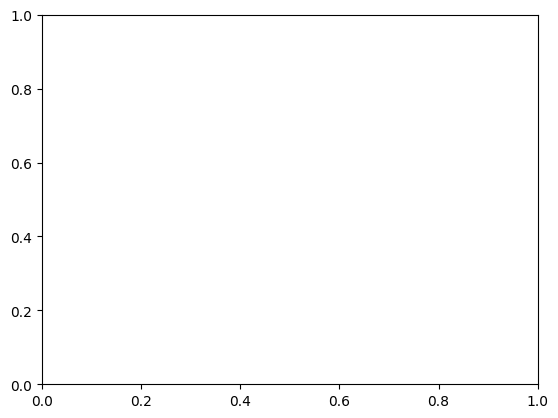

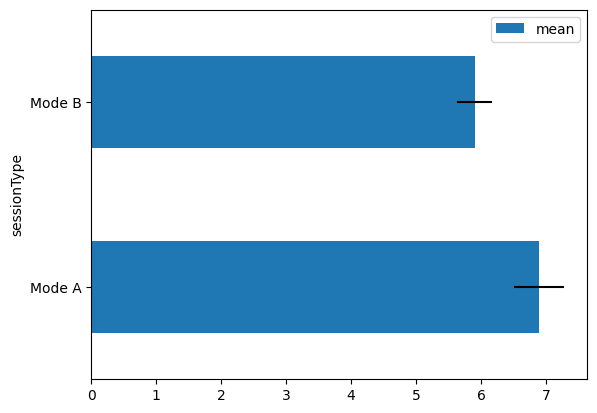

In [311]:
def PrintTaskEventStats(df, title=None):
    print(title)
    layerableDf = df[(df["eventName"] == "EndTask") & (df["sessionType"] == "Mode A")]
    immersiveDf = df[(df["eventName"] == "EndTask") & (df["sessionType"] == "Mode B")]
    print(f"Layerable N: {layerableDf['eventName'].count()}, Immersive N: {immersiveDf['eventName'].count()}")

    layerableAvgScore = layerableDf['score'].mean()
    layerableScoreStd = layerableDf['score'].std()
    layerableScoreSem = layerableDf['score'].sem()

    print(f"Layerable Score: M {layerableAvgScore:.2f} | SD {layerableScoreStd:.2f} | SE {layerableScoreSem:.2f}")

    immersiveAvgScore = immersiveDf['score'].mean()
    immersiveScoreStd = immersiveDf['score'].std()
    immersiveScoreSem = immersiveDf['score'].sem()

    print(f"Immersive Score: M {immersiveAvgScore:.2f} | SD {immersiveScoreStd:.2f} | SE {immersiveScoreSem:.2f}")

    # sortedLayerableScores  = layerableDf[['realID', 'score', 'unixTime']].sort_values(by='unixTime').rename(columns={'score': 'layerableScore'}).reset_index()
    # sortedImmersiveScores = immersiveDf[['realID', 'score', 'unixTime']].sort_values(by='unixTime').rename(columns={'score': 'immersiveScore'}).reset_index()
    # # print(sortedImmersiveScores)

    # scorePlotDf = sortedLayerableScores.join(sortedImmersiveScores['immersiveScore'])
    # scorePlotDf = scorePlotDf[['layerableScore', 'immersiveScore']]

    # scorePlotDf.plot(kind="barh", y = "mean", xerr = "std", title = title)

    # print(scipy.stats.ttest_ind(layerableDf['score'], immersiveDf['score']))
    print(scipy.stats.ttest_rel(layerableDf['score'], immersiveDf['score']))

    plotDf = df[df['eventName'] == 'EndTask'][['sessionType', 'score']]
    plotDf = plotDf.groupby("sessionType").score.agg([np.mean, scipy.stats.sem])

    # barplot = plotDf.plot(kind="barh", y = "mean", xerr = "sem", title = title)
    barplot = plotDf.plot.barh(y = "mean", xerr = "sem")


PrintTaskEventStats(experimentsDf, title="----- ALL TRIALS -----")
print("\n")

noTrainingDf = experimentsDf[experimentsDf['taskOrder'] >= 4]
PrintTaskEventStats(noTrainingDf, title="----- EXCLUDE TRAINING TRIALS -----")
print("\n")

expertsDf = experimentsDf[experimentsDf['realID'].isin([34, 32, 30, 33, 36, 35, 57, 41, 59, 51, 43, 78, 46, 68, 61, 83, 53, 54, 65, 69, 79, 74, 86, 82])]
PrintTaskEventStats(expertsDf, title="----- EXPERTS TRIALS -----")

In [254]:
codeEvents = framesDf[framesDf['codesEvents'].str.len() > 0].codesEvents.tolist()
codesUnpacked = list(itertools.chain(*codeEvents))
codesDf = pandas.DataFrame(codesUnpacked).sort_values(by="unixTime").reset_index()

timezone = pytz.timezone('US/Pacific')

def readableDatetime(row):
    dt = pandas.to_datetime(row.unixTime, unit='ms')
    return dt.tz_localize('UTC').tz_convert('US/Pacific')

codesDf['dateTime'] = codesDf.apply(lambda row: readableDatetime(row), axis=1)

def getMatchingTimeRange(row, validTimeRanges):
    for timeRange in validTimeRanges:
        if (row.unixTime > timeRange[2] and row.unixTime < timeRange[3]):
            return timeRange
    else:
        return None

def getIsValid(row, validTimeRanges):
    return any(row.unixTime > timeRange[2] and row.unixTime < timeRange[3] for timeRange in validTimeRanges)

def getRealID(row, validTimeRanges):
    matchingRange = getMatchingTimeRange(row, validTimeRanges)
    return matchingRange[0] if matchingRange is not None else None

def getSessionType(row, validTimeRanges):
    matchingRange = getMatchingTimeRange(row, validTimeRanges)
    return matchingRange[1] if matchingRange is not None else None

codesDf['isValid'] = codesDf.apply(lambda row: getIsValid(row, timeRanges), axis=1)
codesDf['sessionType'] = codesDf.apply(lambda row: getSessionType(row, timeRanges), axis=1)
codesDf['realID'] = codesDf.apply(lambda row: getRealID(row, timeRanges), axis=1)

codesDf = codesDf[codesDf['isValid'] == True]

codesDf['failCount'] = codesDf.apply(lambda row: 1 if row['success'] == False else 0, axis=1)
codesDf['successCount'] = codesDf.apply(lambda row: 1 if row['success'] == True else 0, axis=1)


In [255]:

# Number of errors
layerableFailCounts = codesDf[codesDf['sessionType'] == 'Mode A'].groupby('realID')['failCount'].sum()
immersiveFailCounts = codesDf[codesDf['sessionType'] == 'Mode B'].groupby('realID')['failCount'].sum()
layerableFailMean = layerableFailCounts.mean()
layerableFailStd = layerableFailCounts.std()
immersiveFailMean = immersiveFailCounts.mean()
immersiveFailStd = immersiveFailCounts.std()

print(f"Layerable Num Fails: {layerableFailMean:.3f} ± {layerableFailStd:.3f}")
print(f"Immersive Num Fails: {immersiveFailMean:.3f} ± {immersiveFailStd:.3f}")

print(scipy.stats.ttest_ind(layerableFailCounts, immersiveFailCounts))
print(scipy.stats.ttest_rel(layerableFailCounts, immersiveFailCounts))


Layerable Num Fails: 1.707 ± 1.707
Immersive Num Fails: 1.659 ± 2.020
Ttest_indResult(statistic=0.11811801751674392, pvalue=0.9062702198207788)
Ttest_relResult(statistic=0.1332149726057591, pvalue=0.8946913159386288)


In [256]:

# Error rates
layerableTotalsDf = codesDf[codesDf['sessionType'] == 'Mode A'].groupby('realID')['success'].count().reset_index()
layerableTotalsDf = layerableTotalsDf.rename(columns={'success' : 'total'})
immersiveTotalsDf = codesDf[codesDf['sessionType'] == 'Mode B'].groupby('realID')['success'].count().reset_index()
immersiveTotalsDf = immersiveTotalsDf.rename(columns={'success' : 'total'})

layerableTotalsDf = layerableTotalsDf.join(layerableFailCounts, on='realID')
layerableTotalsDf['errorRate'] = layerableTotalsDf.apply(lambda row: row['failCount'] / row['total'], axis=1)

immersiveTotalsDf = immersiveTotalsDf.join(immersiveFailCounts, on='realID')
immersiveTotalsDf['errorRate'] = immersiveTotalsDf.apply(lambda row: row['failCount'] / row['total'], axis=1)

layerableAvgError = layerableTotalsDf['errorRate'].mean()
layerableErrorStd = layerableTotalsDf['errorRate'].std()

print(f"Layerable Error Rate: {layerableAvgError:.5f} ± {layerableErrorStd:.5f}")

immersiveAvgError = immersiveTotalsDf['errorRate'].mean()
immersiveErrorStd = immersiveTotalsDf['errorRate'].std()

print(f"Immersive Error Rate: {immersiveAvgError:.5f} ± {immersiveErrorStd:.5f}")

print(scipy.stats.ttest_ind(layerableTotalsDf['errorRate'], immersiveTotalsDf['errorRate']))
print(scipy.stats.ttest_rel(layerableTotalsDf['errorRate'], immersiveTotalsDf['errorRate']))

Layerable Error Rate: 0.11031 ± 0.11418
Immersive Error Rate: 0.11259 ± 0.12406
Ttest_indResult(statistic=-0.0868002569316258, pvalue=0.9310471745115505)
Ttest_relResult(statistic=-0.10545814558075492, pvalue=0.9165393603008123)


In [257]:
# Extract per-user app events

framesWithAppEvents = framesDf[framesDf['appEvents'].str.len() > 0]



# appEvents = framesDf[framesDf['appEvents'].str.len() > 0].appEvents.tolist()
# appsUnpacked = list(itertools.chain(*appEvents))
# appsDf = pandas.DataFrame(appsUnpacked).sort_values(by='unixTime')
# appsDf